# Creating building models using point cloud classification

- 🔬 Data Science
- 🥠 Deep Learning
- 🌍 GIS
- ☁️ Point Cloud Classification

<p align="center">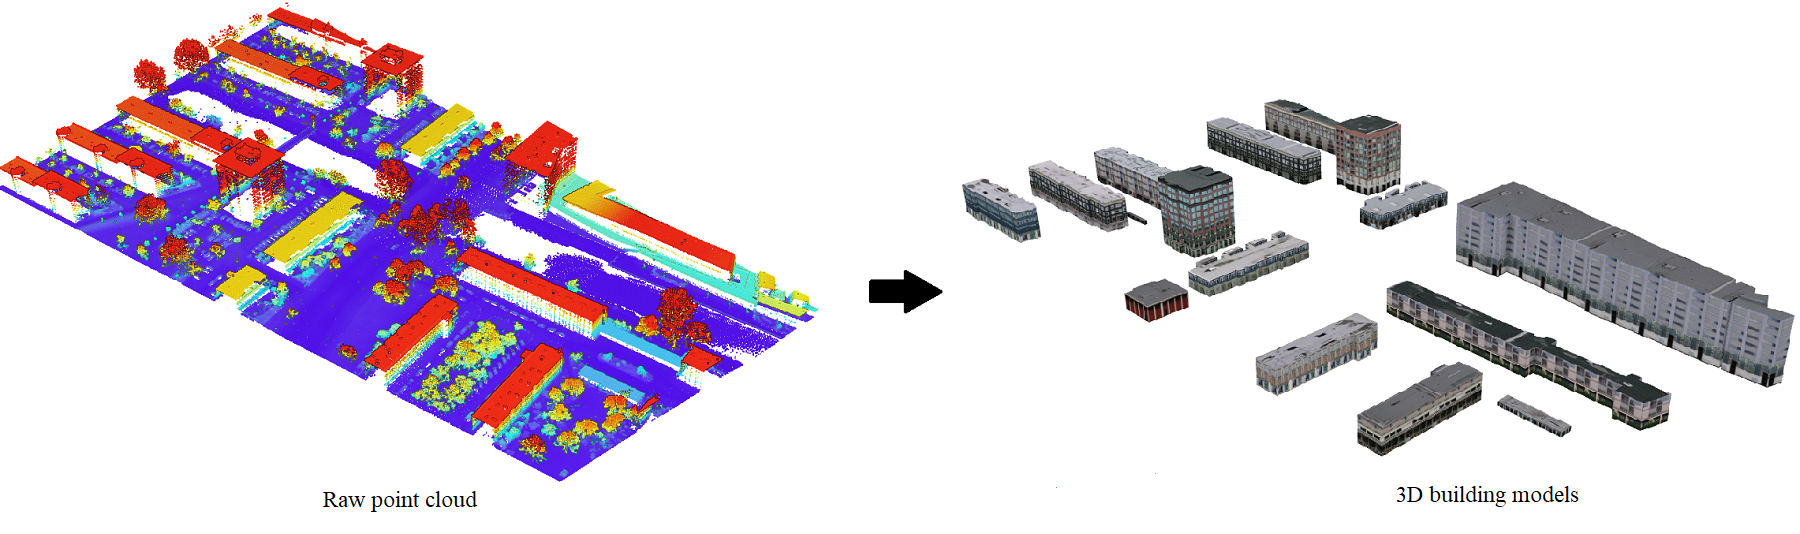</p>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Area-of-interest-and-pre-processing" data-toc-modified-id="Area-of-interest-and-pre-processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Area of interest and pre-processing</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Visualization-of-prepared-data" data-toc-modified-id="Visualization-of-prepared-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualization of prepared data</a></span></li><li><span><a href="#Training-the-model" data-toc-modified-id="Training-the-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training the model</a></span></li><li><span><a href="#Visualization-of-results-in-notebook" data-toc-modified-id="Visualization-of-results-in-notebook-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualization of results in notebook</a></span></li><li><span><a href="#Saving-the-trained-model" data-toc-modified-id="Saving-the-trained-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Saving the trained model</a></span></li><li><span><a href="#Classification-using-the-trained-model" data-toc-modified-id="Classification-using-the-trained-model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Classification using the trained model</a></span></li><li><span><a href="#Post-processing-in-ArcGIS-Pro-and-City-Engine" data-toc-modified-id="Post-processing-in-ArcGIS-Pro-and-City-Engine-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Post-processing in ArcGIS Pro and City Engine</a></span></li><li><span><a href="#Visualization-of-results-in-ArcGIS-Pro" data-toc-modified-id="Visualization-of-results-in-ArcGIS-Pro-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Visualization of results in ArcGIS Pro</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#References" data-toc-modified-id="References-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Introduction

Classification of point clouds has always been a challenging task, due to its naturally unordered data structure. The workflow described in this sample is about going from raw unclassified point clouds to digital twins: near-perfect representation of real-world entities. Within the scope of this sample, we are only interested in 'digital twins of buildings' <i>(3D building multipatches/models)</i>. This work can also be used for guidance, in other relevant use-cases for various objects of interest.

First, deep learning capabilities in 'ArcGIS API for Python' are utilized for point cloud classification, then 'ArcGIS Pro' and 'City Engine' are used for the GIS-related post-processing.

Further details on the PointCNN implementation in the API <i>(working principle, architecture, best practices, etc.)</i>, can be found in the <a href="https://developers.arcgis.com/python/guide/point-cloud-segmentation-using-pointcnn" target="_blank">PointCNN guide</a>, along with instructions on how to set up the Python environment. Additional sample notebooks related to PointCNN can be found in the <a href="https://developers.arcgis.com/python/sample-notebooks/" target="_blank">sample notebook section</a> on the website.

Before proceeding through this notebook, it is advised that you go through the <a href="https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#pointcnn" target="_blank">API reference</a> for PointCNN (`prepare_data()`, `Transform3d()`, and `PointCNN()`), along with the resources and tool references for point cloud classification using deep learning in ArcGIS Pro, found <a href="https://pro.arcgis.com/en/pro-app/latest/help/data/las-dataset/introduction-to-deep-learning-and-point-clouds.htm" target="_blank">here</a>.

_**Objectives:**_

<ol style="list-style-type:upper-roman">
<li>Classify building points using API's PointCNN model, where we train it for two classes: viz. 'Buildings' and 'Background'.</li>
<br>
<li>Generate 3D building multipatches, from classified building points using 'ArcGIS Pro' and 'City Engine'.</li>
</ol>

## Area of interest and pre-processing

Any airborne point cloud dataset and area of interest can be used. But for this sample, <a href="https://downloads.pdok.nl/ahn3-downloadpage/" target="_blank"> AHN3 dataset</a>, provided by the Government of The Netherlands is considered <a href="#References">[1]</a>, which is one of the highest quality open datasets available currently, in terms of accurate labels and point density. While the area of interest for this work is 'Amsterdam' and its nearby regions. Its unique terrain with canals and from modern to 17<sup>th</sup> - century architecture style makes it a good candidate for a sample.

_**Pre-processing steps:**_

- Uncompress, the downloaded AHN3 dataset's `.laz` files, into `.las` format. <i>(Refer, ArcGIS Pro's <a href="https://pro.arcgis.com/en/pro-app/tool-reference/conversion/convert-las.htm" target="_blank">Convert LAS</a> tool.)</i>


- Reassign class codes, so that only two classes remain in the data: ‘Buildings’ and ‘Background’ <i>(Refer, ArcGIS Pro's <a href="https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/change-las-class-codes.htm" target="_blank">Change LAS Class Codes</a> tool)</i>. In this sample, ASPRS-defined class codes are followed <i>(optional, for the PointCNN workflow)</i>. Hence, '6' is used to represent 'Buildings'. And reserved-class code '19' is used to represent 'Background' <i>(rest of the points)</i>, as it is also a class which the model will learn about, along with 'Buildings' class. So, the class code for 'points in undefined state': '1' and ' points in never-classified state': '0', are not used to represent 'Background' class.
 

- Split the `.las` files into three unique sets, one for training, one for validation, and one for testing. Create LAS datasets for all three sets using the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/create-las-dataset.htm" target="_blank">'Create LAS Dataset'</a>  tool. There is no fixed rule, but generally, the validation data for point clouds in `.las` format should be at least 5-10 % <i>(by size)</i> of the total data available, with appropriate diversity within the validation dataset. <i>(For ease in splitting the big `.las` files into the appropriate ratios, ArcGIS Pro's <a href="https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/tile-las.htm" target="_blank">'Tile LAS'</a> tool can be used.)</i>


- Alternatively, polygons can also be used to define regions of interest that should be considered as training or validation datasets. These polygons can be used later in the export tool. If the dataset is very large, then the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/build-las-dataset-pyramid.htm" target="_blank">'Build LAS Dataset Pyramid'</a> tool can be leveraged for faster rendering/visualization of the data, which will also help in exploring and splitting the dataset.  

## Data preparation

_**Imports:**_

In [ ]:
from arcgis.learn import prepare_data, Transform3d, PointCNN
from arcgis.gis import GIS
gis = GIS()

**Note:** The data used in this sample notebook can be downloaded as a zip file, from <a href="https://arcg.is/0jzODe"  target="_blank">here</a>. It contains both 'training data' and 'test data', where the 'test data' is used for inferencing. It can also be accessed via its `itemId`, as shown below.

In [ ]:
training_data = gis.content.get('50390f56a0e740ac88c72ae1fb1eda7a')
training_data

<Item title:"Creating_building_models_using_point_cloud_classification" type:Image Collection owner:api_data_owner>

_**Exporting the data:**_

In this step, `.las` files are converted to a 'HDF5 binary data format'. For this step of exporting the data into an intermediate format, use the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-training-data.htm" target="_blank">Prepare Point Cloud Training Data</a> tool in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, available from ArcGIS Pro 2.8 onwards <i>(as shown in figure 1)</i>.

The tool needs two LAS datasets, one for the training data and one for the validation data or regions of interest defined by polygons. Next, the `block size` is set to '50 meters', as our objects of interest will mostly be smaller than that, and the default value of '8192' is used for `block point limit`.



<p align="center">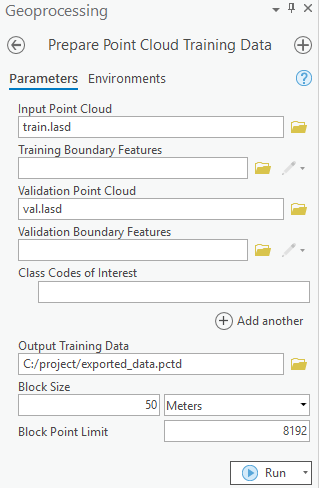</p>

<center>Figure 1. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-training-data.htm" target="_blank">Prepare Point Cloud Training Data</a> tool.</center>



Here, all the additional attributes are included in the exported data. Later, a subset of additional attributes like intensity, number of returns, etc. can be selected that will be considered for training.

After the export is completed at the provided output path, the folder structure of the exported data will have two folders, each with converted HDF files in them <i>(as shown in figure 2)</i>. The exported training and validation folders will also contain histograms of the distributions of data that provide additional understanding and can help in tweaking the parameters that are being used in the workflow.

<p align="center">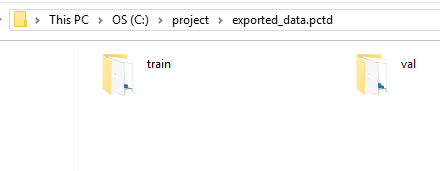</p>

<center>Figure 2. Exported data.</center>

_**Preparing the data:**_

For `prepare_data()`, deciding the value of `batch_size` will depend on either the available RAM or VRAM, depending upon whether CPU or GPU is being used. `transforms` can also be used for introducing rotation, jitter, etc. to make the dataset more robust. `data.classes` can be used to verify what classes the model will be learning about.

The `classes_of_interest` and `min_points` parameters can be used to filter out less relevant blocks. These parameters are useful when training a model for SfM-derived or mobile/terrestrial point clouds. In specific scenarios when the 'training data' is not small, usage of these features can result in speeding up the 'training time', improving the convergence during training, and addressing the class imbalance up to some extent.

In this sample notebook X, Y, Z, and intensity are considered for training the model. So, 'intensity' is selected as `extra_features`. The names of the classes are also defined using `class_mapping` and will be saved inside the model for future reference.

In [ ]:
output_path = r'C:\project\exported_data.pctd'

In [ ]:
colormap = {'6':[255,69,0], '19':[253,247,83]}

In [ ]:
data = prepare_data(output_path, 
                    dataset_type='PointCloud',
                    batch_size=2,
                    transforms=None,
                    color_mapping=colormap,
                    extra_features=['intensity'],
                    class_mapping={'6':'building','19':"background"})

In [ ]:
data.classes

## Visualization of prepared data

`show_batch()` helps in visualizing the exported data. Navigation tools available in the graph can be used to zoom and pan to the area of interest.

In [ ]:
data.show_batch(rows=1)

<p align="center"><img src="../../static/img/pointcnn_sample1_show_b.gif" /></p>

<center>Figure 3. Visualization of batch.</center>

## Training the model

First, the PointCNN model object is created, utilizing the prepared data.

In [ ]:
pc = PointCNN(data)

Next, the `lr_find()` function is used to find the optimal learning rate that controls the rate at which existing information will be overwritten by newly acquired information throughout the training process. If no value is specified, the optimal learning rate will be extracted from the learning curve during the training process.

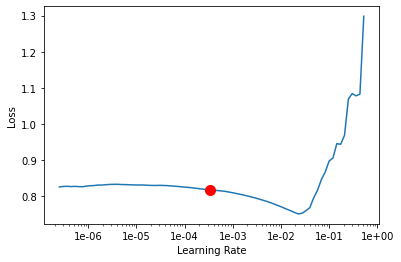

0.0003311311214825911

In [ ]:
pc.lr_find()

The `fit()` method is used to train the model, either applying a new 'optimum learning rate' or the previously computed 'optimum learning rate' <i>(any other user-defined learning rate can also be used.)</i>.

If `early_stopping` is set to 'True', then the model training will stop when the model is no longer improving, regardless of the `epochs` parameter value specified. The best model is selected based on the metric selected in the `monitor` parameter. A list of `monitor`'s available metrics can be generated using the `available_metrics` property.

An 'epoch' means the dataset will be passed forward and backward through the neural network one time, and if `Iters_per_epoch` is used, a subset of data is passed per epoch. To track information like gradients, losses, metrics, etc. while the model training is in progress, `tensorboard` can be set to 'True'.


In [ ]:
pc.available_metrics

['valid_loss', 'accuracy', 'precision', 'recall', 'f1']

In [ ]:
pc.fit(30, 0.0003311311214825911, monitor='f1', tensorboard=True, early_stopping=True)

Monitor training on Tensorboard using the following command: 'tensorboard --host=DEMOPC01 --logdir="C:\project\exported_data.pctd\training_log"'


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.414868,0.327828,0.961552,0.580412,0.500773,0.491984,51:46
1,0.180299,0.152622,0.961906,0.558456,0.508025,0.498137,52:12
2,0.134608,0.114754,0.962637,0.732194,0.521849,0.530341,53:02
3,0.115696,0.103849,0.965638,0.740362,0.578991,0.606499,55:15
4,0.101456,0.083759,0.972504,0.758468,0.641700,0.676384,53:07
5,0.091657,0.078313,0.978683,0.764146,0.716316,0.732368,53:41
6,0.077390,0.055922,0.984198,0.810564,0.738881,0.767787,1:02:30
7,0.062161,0.056305,0.984254,0.809325,0.730631,0.760365,1:05:56
8,0.053943,0.040296,0.987276,0.816530,0.765274,0.785336,1:06:09
9,0.046304,0.041236,0.986681,0.814050,0.764801,0.783799,1:05:47


Epoch 22: early stopping


## Visualization of results in notebook

`show_results()` will visualize the results of the model for the same scene as the ground truth. Navigation tools available in the graph can be used to zoom and pan to the area of interest.

The `compute_precision_recall()` method can be used to compute per-class performance metrics, which are calculated against the validation dataset.

In [ ]:
pc.show_results(rows=1)

<p align="center"><img src="../../static/img/pointcnn_sample1_show_r.gif" /></p>

<center>Figure 4. Visualization of results.</center>

## Saving the trained model

The last step related to training is to save the model using the `save()` method. Along with the model files, this method also saves performance metrics, a graph of training loss vs validation loss, sample results, etc. <i>(as shown in figure 5)</i>.

<p align="center">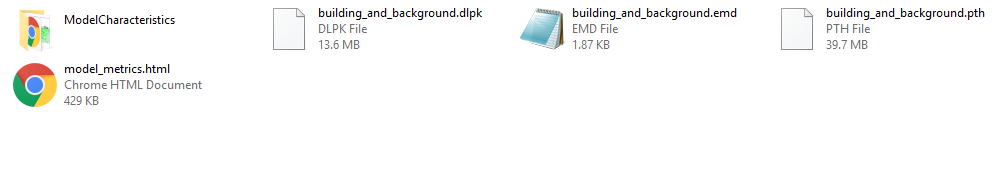</p>

<center>Figure 5. Saved model.</center>

In [ ]:
pc.save('building_and_background')

WindowsPath('models/building_and_background')

## Classification using the trained model

For inferencing, <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, available from ArcGIS Pro 2.8 onwards, can be used <i>(as shown in figure 6)</i>.


<p align="center">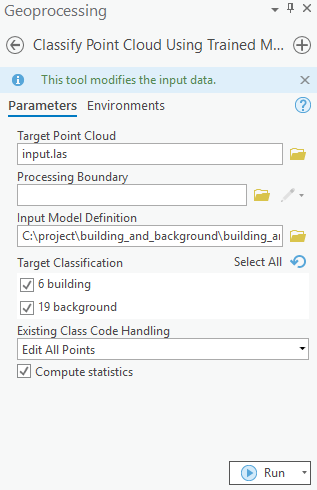</p>

<center>Figure 6. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool.</center>



Additional features, like target classification and class preservation in input data, are also available. After the prediction, LAS files will have 'building points', with the class code '6', and the rest of the points will have the class code '19' <i>(referred to as 'Background' in this sample)</i>. To visualize the results after the process is completed, the 'Symbology' can be changed to 'class' from the 'Appearance' tab, if not done initially.

## Post-processing in ArcGIS Pro and City Engine

There can be multiple unsupervised/semi-supervised workflows to clean the noise and generate building footprints from classified building points. The method used for this work is described below: 

We start with PointCNN's classified building points<i> (as shown in figure 7)</i>. 

<p align="center">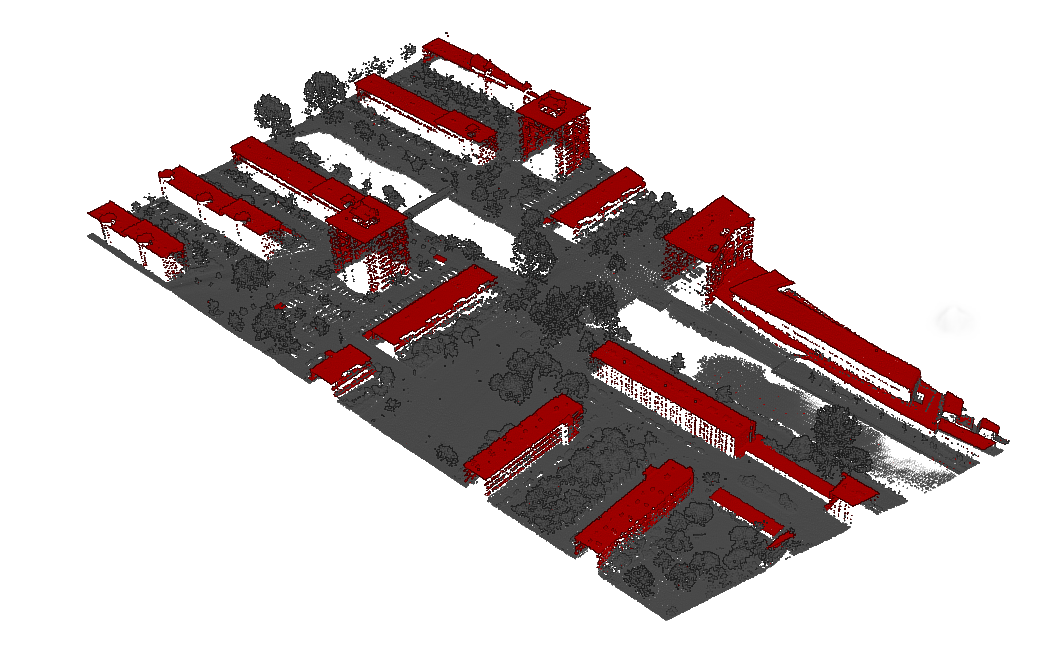</p>

<center>Figure 7. Visualization of results in ArcGIS Pro.</center>


_**Model Builder:**_

Then using multiple geoprocessing tools in ArcGIS Pro within a model builder, noises are cleaned and building footprints are generated. These footprints are later used to generate multipatches. 

The model builder used in this sample can be downloaded from <a href="https://arcg.is/0Kvi0r" target="_blank">here</a> . The model builder can be used via its tool UI <i>(as shown in figure 8.1)</i>, or it can also be used via the model builder wizard in ArcGIS Pro <i>(as shown in figure 8.2)</i>. If needed the workflow can be also be edited/customized.


<p align="center">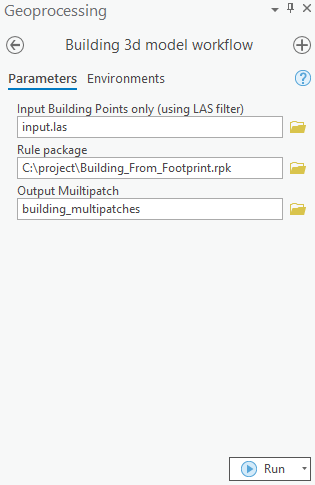</p>


<center>Figure 8.1. Model builder tool UI.</center>


<p align="center">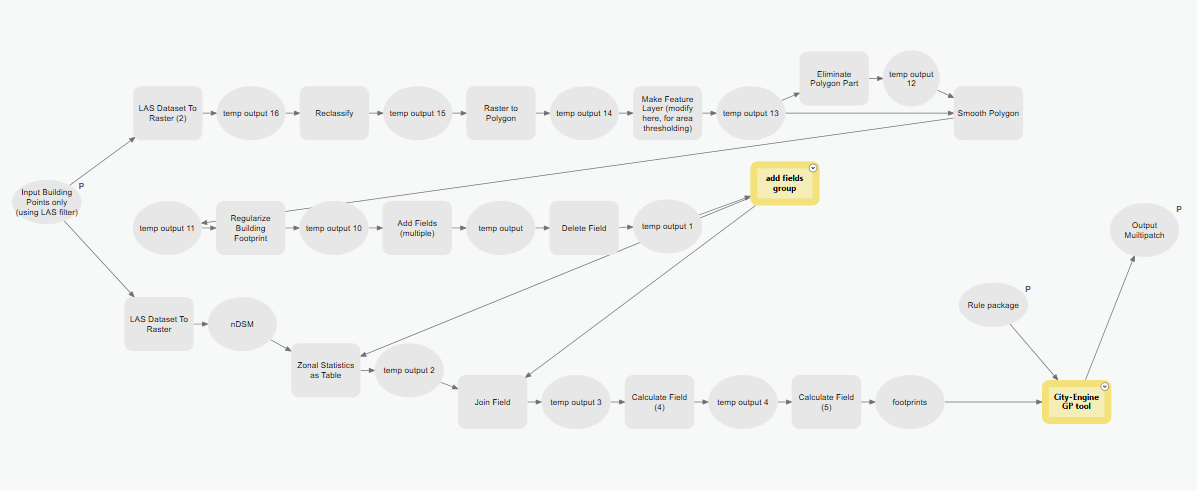</p>


<center>Figure 8.2. Model builder.</center>


The model builder takes filtered 'building points' as 'input' <i>('LAS filter' can be used for this, as shown in figure 9)</i>. In this post-processing pipeline, important prior information is that "no building will have a very small area". This information is used to apply 'area-based thresholding' using <a href="https://pro.arcgis.com/en/pro-app/help/mapping/navigation/select-features-using-attributes.htm" target="_blank">Select by Attribute</a> and reduce the noise polygons generated from noise points. If needed, this 'area-based threshhold value' can be changed by editing the model builder.


<p align="center">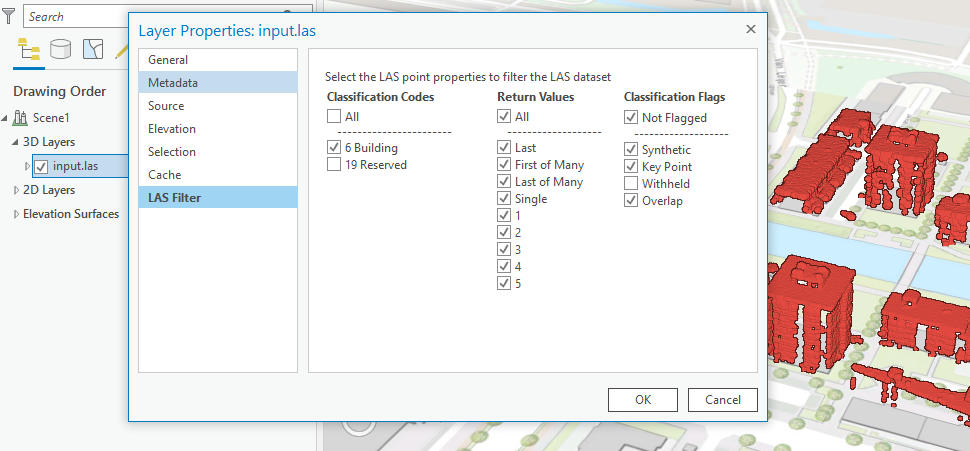</p>

<center>Figure 9. Filtering of points. </center>


After smoothening and regularizing the polygons <i>(as shown in figure 10)</i>,
<a href="https://pro.arcgis.com/en/pro-app/tool-reference/spatial-analyst/zonal-statistics.htm"  target="_blank">Zonal Statistics</a> is used to populate the footprint polygon's attribute table with 'avg. building height'. Later, other information like building type, no. of floors, etc. are also added, which are later used by City Engine's rule package to generate better digital twins of buildings.

<p align="center">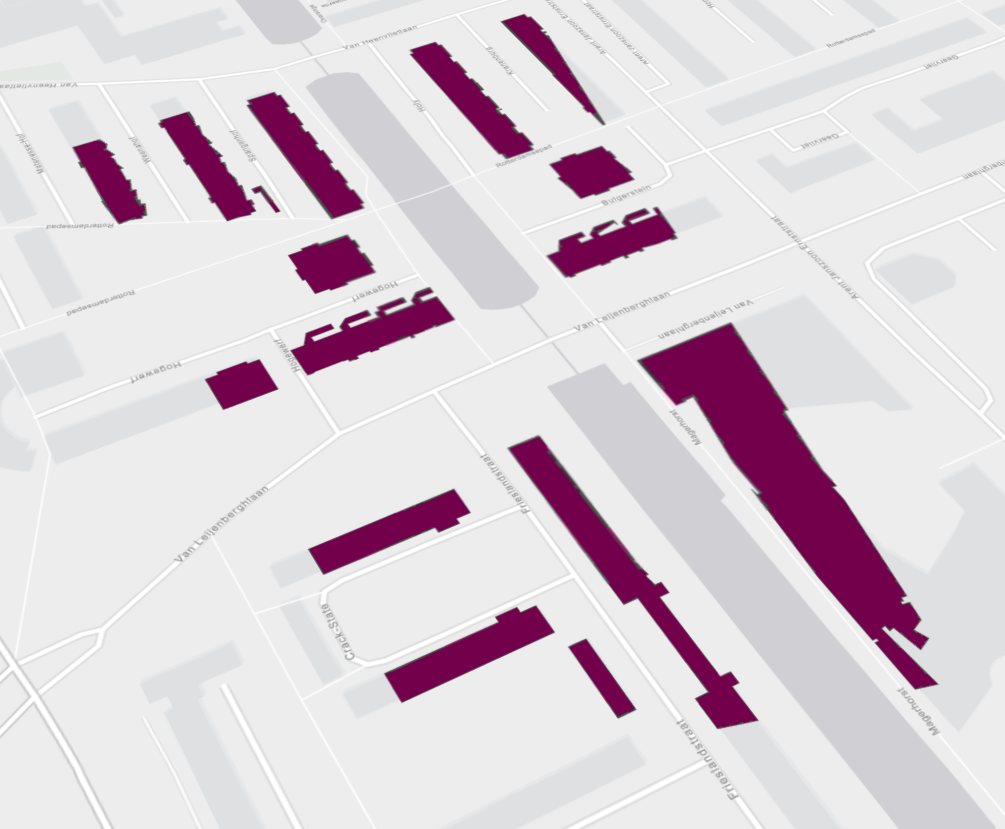</p>

<center>Figure 10. Building footprint.</center>


    
    
    

Lastly, these footprints are used to generate realistic 3D models/multipatches using City Engine's rule packages. Where <a href="https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/features-from-cityengine-rules.htm" target="_blank">Features From CityEngine Rules</a> is used. The rule package used in this sample can be downloaded from <a href="https://arcg.is/05qDXj" target="_blank">here</a>. It is created using City Engine's  CGA rules, and the 'connection attributes' can be noted down from City Engine<i> (as shown in figure 11)</i>. 

<p align="center">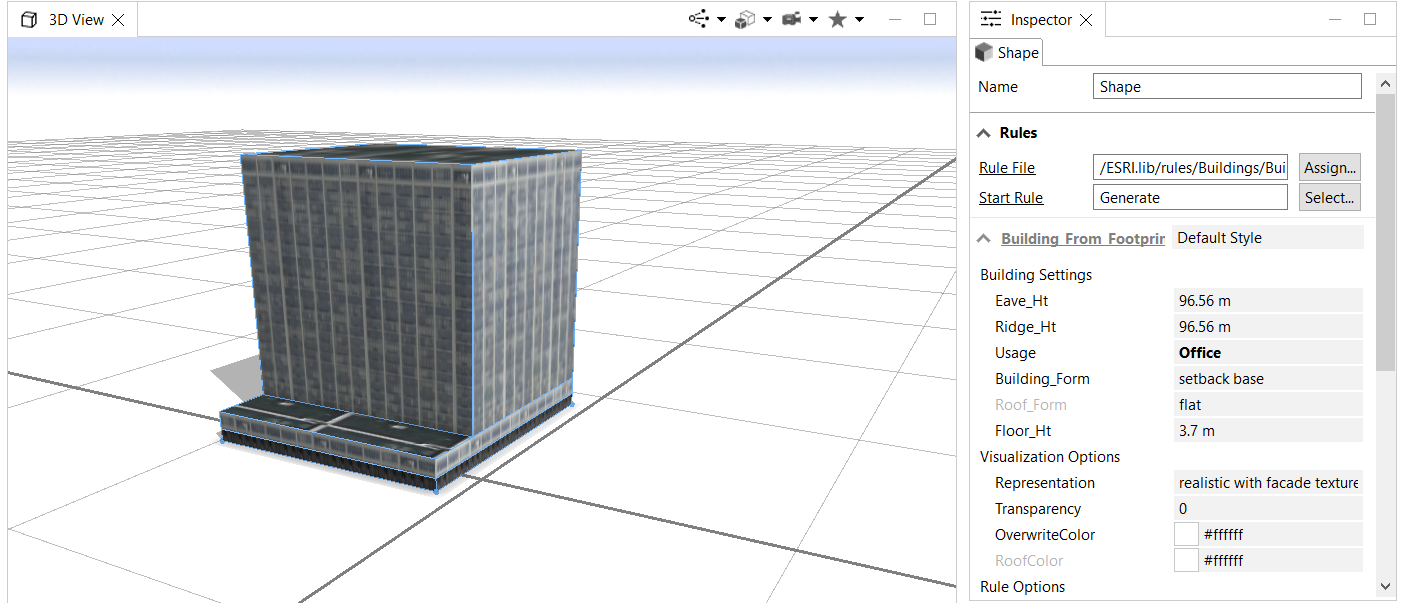</p>

<center>Figure 11. City Engine's CGA rules.</center>



## Visualization of results in ArcGIS Pro

Building Multipatches are the final output of this sample <i>(as shown in figure 12)</i>.
The output is very close to real-world buildings from the 'area of interest', in terms of 'accurate depiction' and 'aesthetics'.


<p align="center">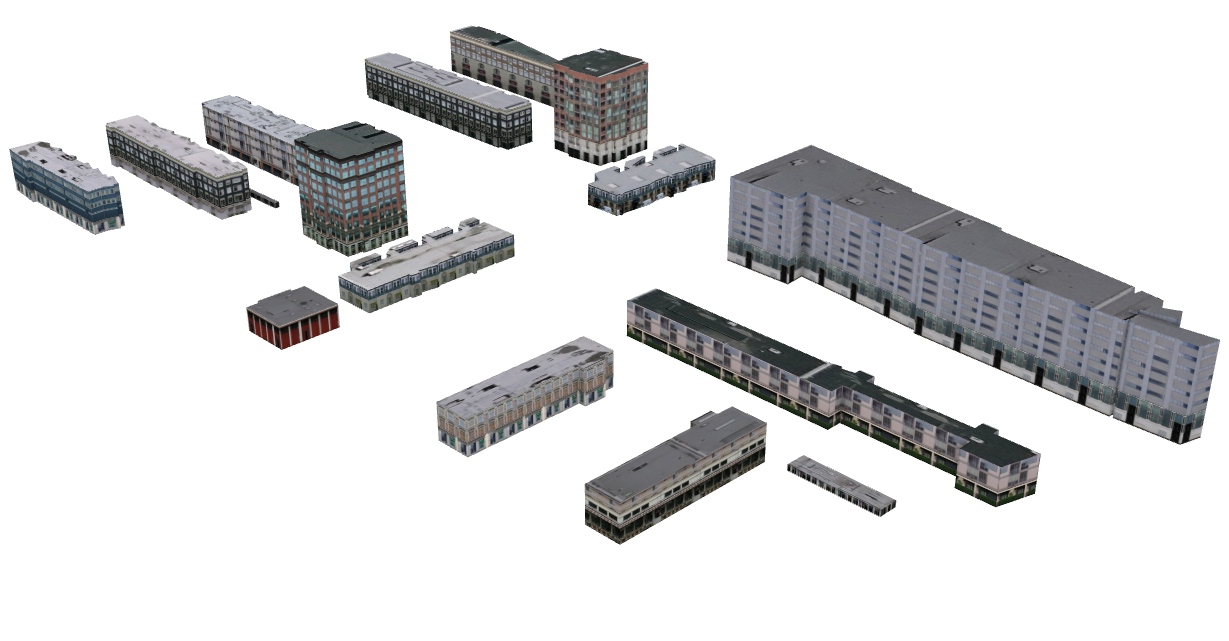</p>

<center>Figure 12. Building Multipatches.</center>

<i> This <a href="https://www.arcgis.com/home/webscene/viewer.html?webscene=908161d7ebfe49e3b318aa7139968ba5" target="_blank">web scene</a> has the final and intermediate outputs related to the illustrated test data in this notebook. It can also be accessed via its `itemId`, as shown below.</i>

<Item title:"Classification of raw point clouds using deep learning & generating 3d building models" type:Web Scene owner:api_data_owner>
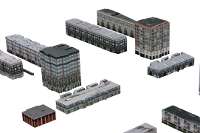

In [ ]:
results = gis.content.get('908161d7ebfe49e3b318aa7139968ba5')
results

## Conclusion

This notebook has walked us through an end-to-end workflow for training a deep learning model for point cloud classification and generating digital twins of real-world objects from the classified points. A similar approach can be applied to classify other objects of interest like trees, traffic lights, wires, etc.

## References

- AHN3 data used in this sample is licensed under the <a href="https://creativecommons.org/publicdomain/zero/1.0/deed.nl" target="_blank">Creative Commons Zero license</a>.